In [4]:
pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 16.3 MB/s eta 0:00:00


In [5]:
import sktime
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error

# **Wind Farm #1**

In [8]:
DATA_PATH = 'Datasets'

df_wf1 = pd.read_excel(
    os.path.join('/','Wind farm site 1 (Nominal capacity-99MW).xlsx'),
)

pd.set_option('display.max_columns', None)
df_wf1

Time(year-month-day h:m:s)  Wind speed at height of 10 meters (m/s)  \
0            2019-01-01 00:00:00                                    2.209   
1            2019-01-01 00:15:00                                    1.828   
2            2019-01-01 00:30:00                                    2.193   
3            2019-01-01 00:45:00                                    2.654   
4            2019-01-01 01:00:00                                    2.249   
...                          ...                                      ...   
70171        2020-12-31 22:45:00                                    5.738   
70172        2020-12-31 23:00:00                                    5.748   
70173        2020-12-31 23:15:00                                    4.468   
70174        2020-12-31 23:30:00                                    3.730   
70175        2020-12-31 23:45:00                                    3.291   

       Wind direction at height of 10 meters (˚)  \
0                                         81.317   
1                                         77.460   
2                                         86.700   
3                                         78.160   
4                                         94.297   
...                                          ...   
70171                                    234.600   
70172                                    229.333   
70173                                    235.133   
70174                                    242.580   
70175                                    243.733   

       Wind speed at height of 30 meters (m/s)  \
0                                        1.991   
1                                        1.698   
2                                        2.313   
3                                        2.494   
4                                        2.192   
...                                        ...   
70171                                    6.408   
70172                                    6.231   
70173                                    4.406   
70174                                    3.280   
70175                                    3.311   

       Wind direction at height of 30 meters (˚)  \
0                                         74.814   
1                                         75.048   
2                                         84.688   
3                                         74.939   
4                                         91.140   
...                                          ...   
70171                                    235.454   
70172                                    233.423   
70173                                    253.261   
70174                                    252.492   
70175                                    254.267   

       Wind speed at height of 50 meters (m/s)  \
0                                        2.094   
1                                        1.757   
2                                        2.344   
3                                        2.574   
4                                        2.558   
...                                        ...   
70171                                    6.575   
70172                                    6.372   
70173                                    4.381   
70174                                    3.204   
70175                                    3.643   

       Wind direction at height of 50 meters (˚)  \
0                                         77.667   
1                                         88.733   
2                                         89.100   
3                                         87.267   
4                                         96.900   
...                                          ...   
70171                                    242.033   
70172                                    239.800   
70173                                    263.400   
70174                                    268.600   
70175                                    266.733   

    

In [12]:
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']

In [13]:
df_wf1.columns = [col.strip() for col in df_wf1.columns]

In [14]:
df_wf1.describe()

WS_10         WD_10         WS_30         WD_30         WS_50  \
count  70176.000000  70176.000000  70176.000000  70176.000000  70176.000000   
mean       5.711011    222.829748      6.039255    220.633957      6.168763   
std        3.119512     73.705902      3.700131     79.846922      3.874708   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.538000    209.431500      3.302000    192.871000      3.194000   
50%        5.389000    235.987000      5.783000    245.442000      5.811000   
75%        7.217250    275.287000      8.091000    277.580250      8.384000   
max       25.465000    358.987000     29.187000    359.087000     29.678000   

              WD_50        WS_cen        WD_cen         Air_T         Air_P  \
count  70176.000000  70176.000000  70176.000000  70176.000000  70176.000000   
mean     221.868203      6.375876    216.986224      8.543324    889.527469   
std       83.092270      3.907965     85.404564     13.368410      2.439019   
min        0.000000      0.000000      0.000000    -24.131000    858.400000   
25%      169.800000      3.300000    144.067000     -3.271000    889.550000   
50%      251.833000      5.879500    248.825000      9.823000    889.742000   
75%      281.433000      8.604000    279.304250     19.756000    889.925000   
max      358.933000     30.247000    358.500000     36.130000    918.192000   

              Air_H     Power(MW)  
count  70176.000000  70176.000000  
mean      37.581143     23.426896  
std       18.896256     24.130181  
min        1.502000      0.000000  
25%       22.355000      1.572839  
50%       34.401500     14.957783  
75%       51.584000     40.215230  
max       93.120000     98.094440

In [15]:
df_wf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       70176 non-null  object 
 1   WS_10      70176 non-null  float64
 2   WD_10      70176 non-null  float64
 3   WS_30      70176 non-null  float64
 4   WD_30      70176 non-null  float64
 5   WS_50      70176 non-null  float64
 6   WD_50      70176 non-null  float64
 7   WS_cen     70176 non-null  float64
 8   WD_cen     70176 non-null  float64
 9   Air_T      70176 non-null  float64
 10  Air_P      70176 non-null  float64
 11  Air_H      70176 non-null  float64
 12  Power(MW)  70176 non-null  float64
dtypes: float64(12), object(1)
memory usage: 7.0+ MB


In [16]:
df_wf1['time'] = pd.to_datetime(df_wf1['time'], format='%Y-%m-%d %H:%M:%S')

In [17]:
df_wf1.isnull().mean()

time         0.0
WS_10        0.0
WD_10        0.0
WS_30        0.0
WD_30        0.0
WS_50        0.0
WD_50        0.0
WS_cen       0.0
WD_cen       0.0
Air_T        0.0
Air_P        0.0
Air_H        0.0
Power(MW)    0.0
dtype: float64

In [18]:
df_wf1

time  WS_10    WD_10  WS_30    WD_30  WS_50    WD_50  \
0     2019-01-01 00:00:00  2.209   81.317  1.991   74.814  2.094   77.667   
1     2019-01-01 00:15:00  1.828   77.460  1.698   75.048  1.757   88.733   
2     2019-01-01 00:30:00  2.193   86.700  2.313   84.688  2.344   89.100   
3     2019-01-01 00:45:00  2.654   78.160  2.494   74.939  2.574   87.267   
4     2019-01-01 01:00:00  2.249   94.297  2.192   91.140  2.558   96.900   
...                   ...    ...      ...    ...      ...    ...      ...   
70171 2020-12-31 22:45:00  5.738  234.600  6.408  235.454  6.575  242.033   
70172 2020-12-31 23:00:00  5.748  229.333  6.231  233.423  6.372  239.800   
70173 2020-12-31 23:15:00  4.468  235.133  4.406  253.261  4.381  263.400   
70174 2020-12-31 23:30:00  3.730  242.580  3.280  252.492  3.204  268.600   
70175 2020-12-31 23:45:00  3.291  243.733  3.311  254.267  3.643  266.733   

       WS_cen   WD_cen   Air_T    Air_P   Air_H  Power(MW)  
0       2.494   74.500 -13.484  889.867  76.320   0.254383  
1       1.882   74.367 -13.691  889.575  76.757   0.329703  
2       2.350   89.000 -13.766  889.942  76.981   0.296306  
3       2.808   82.733 -13.691  889.675  76.821   0.187590  
4       2.924   92.967 -13.447  890.025  74.571   0.081005  
...       ...      ...     ...      ...     ...        ...  
70171   6.680  238.433  -9.108  890.008  53.312  13.633642  
70172   6.448  236.833  -9.978  889.817  53.877   6.869759  
70173   4.399  261.733  -9.808  889.825  54.437   4.352931  
70174   3.446  266.733  -9.633  889.492  54.677   7.185250  
70175   4.306  268.633  -8.991  889.492  53.381  12.384466  

[70176 rows x 13 columns]

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


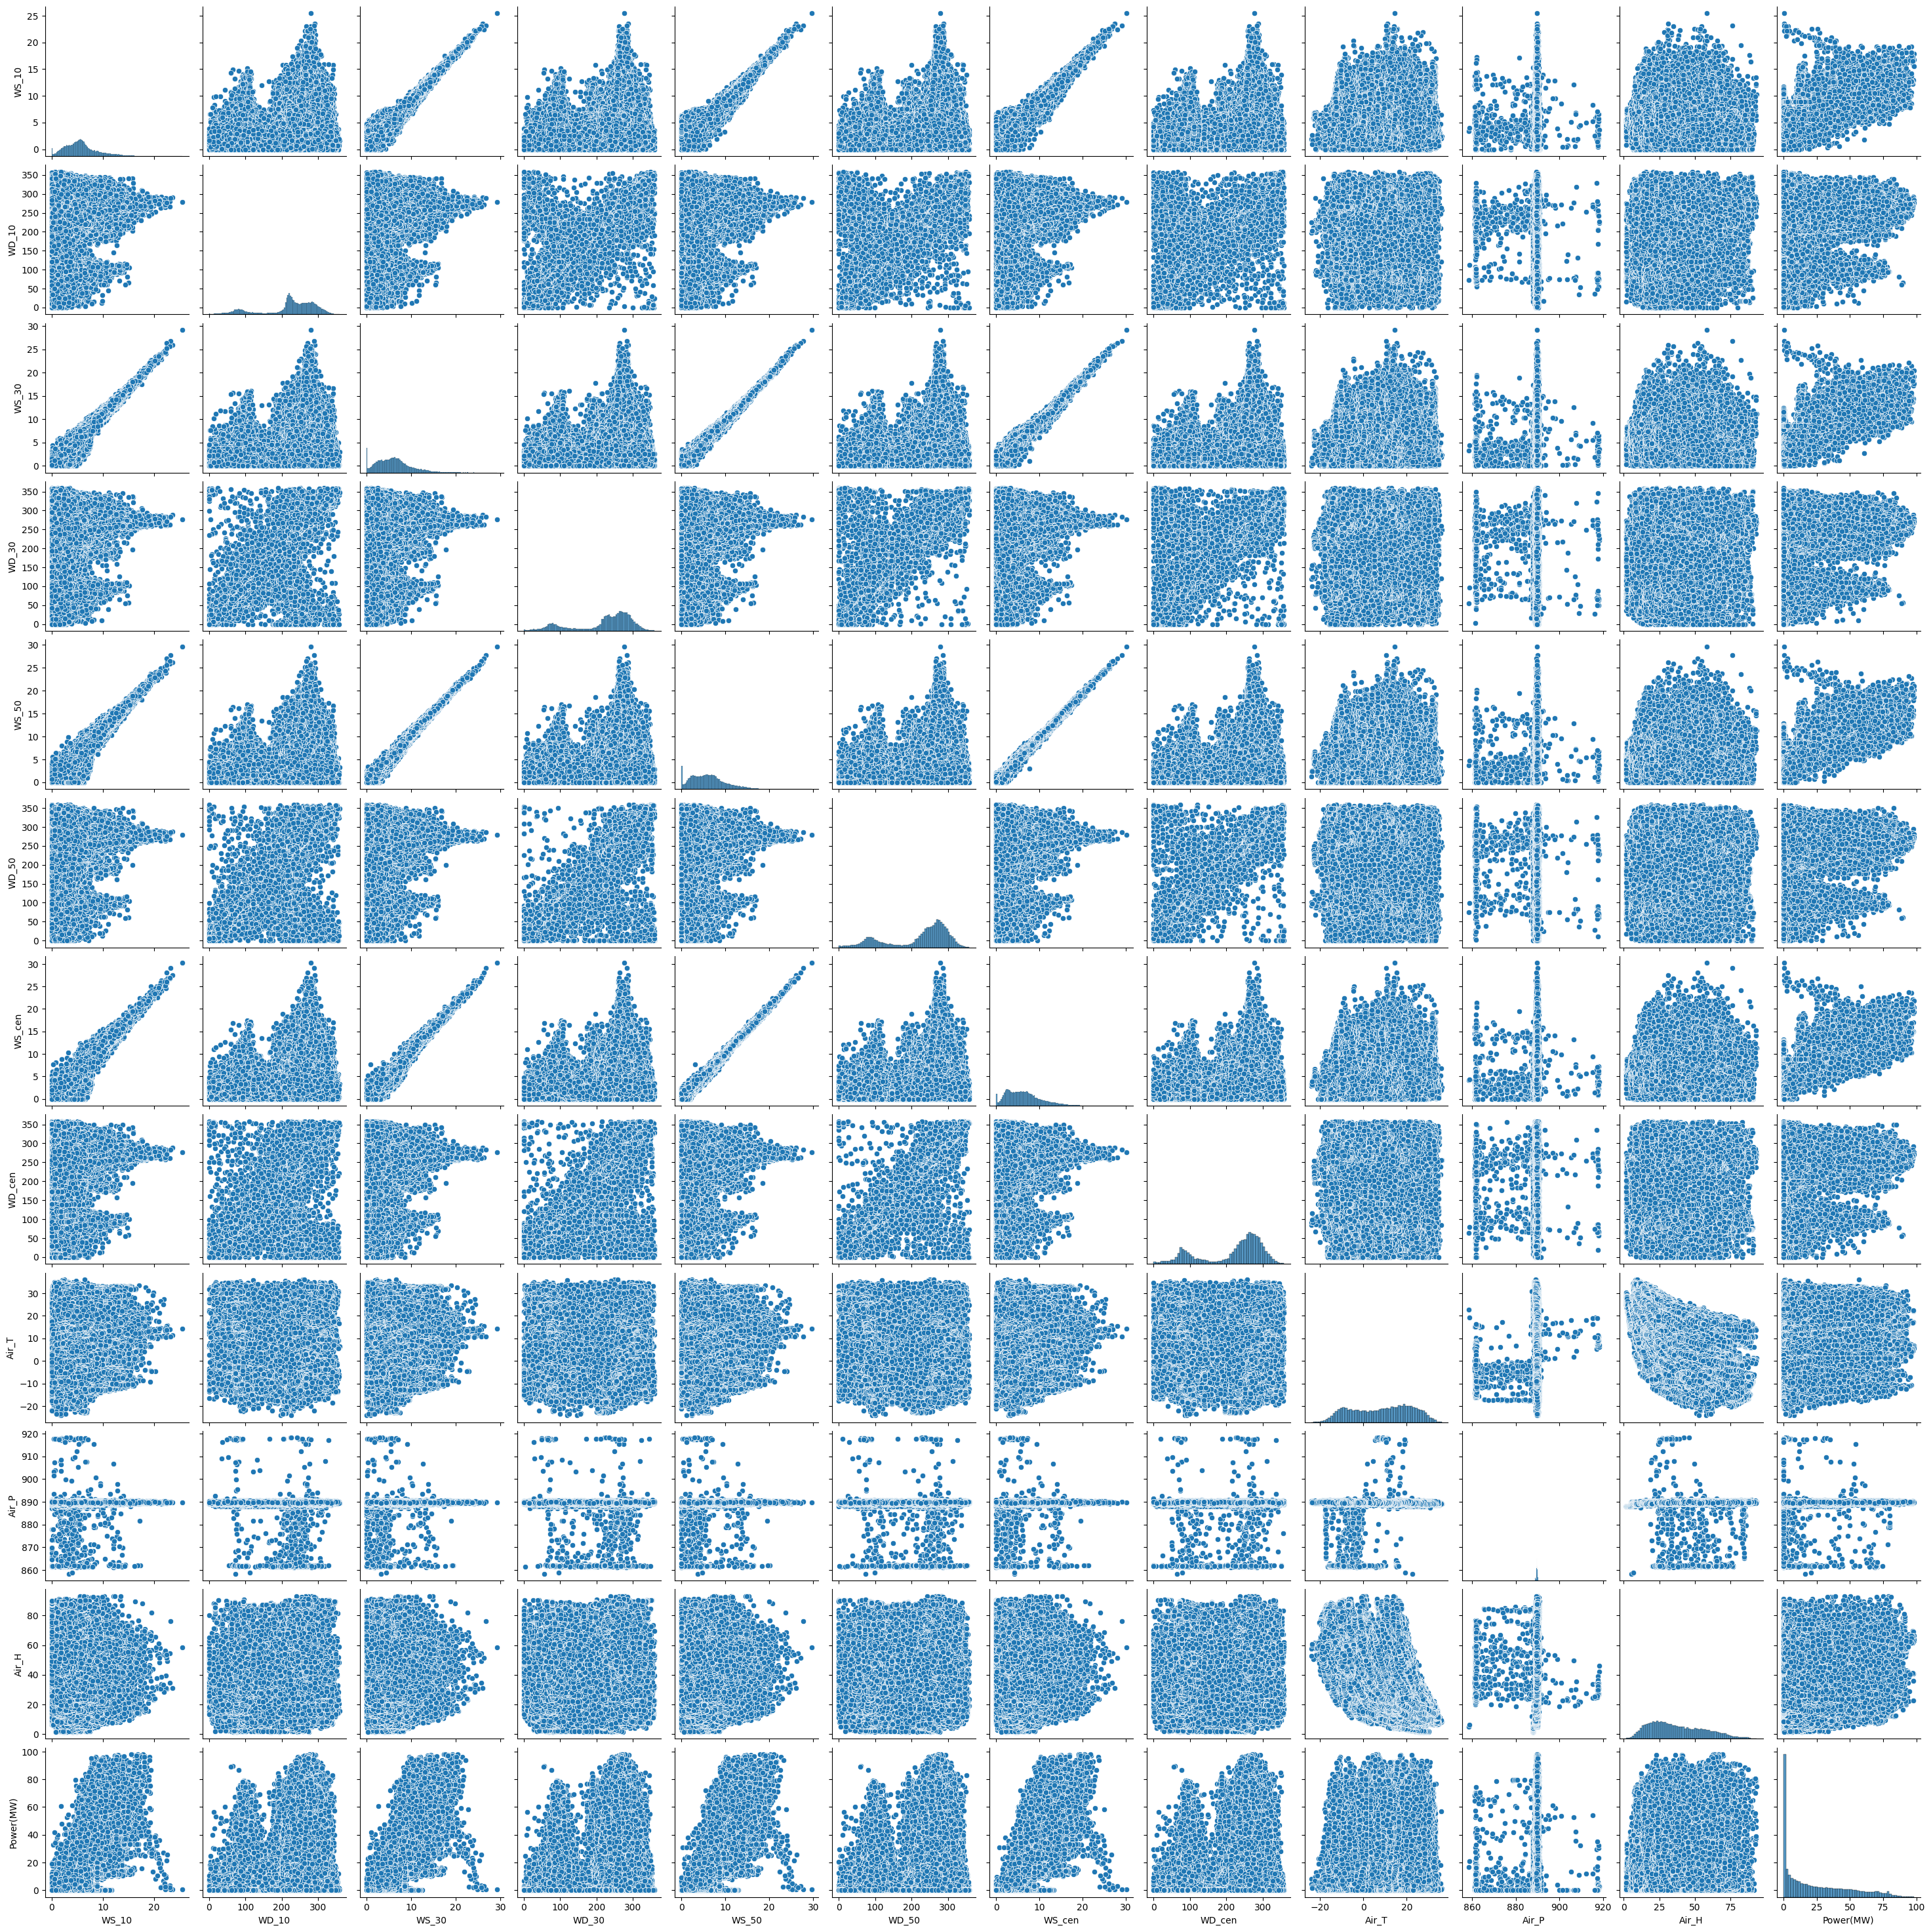

In [19]:

sns.pairplot(df_wf1, hue=None, size=2.5)


<ipython-input-20-e9bb7772e52e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_wf1.corr()


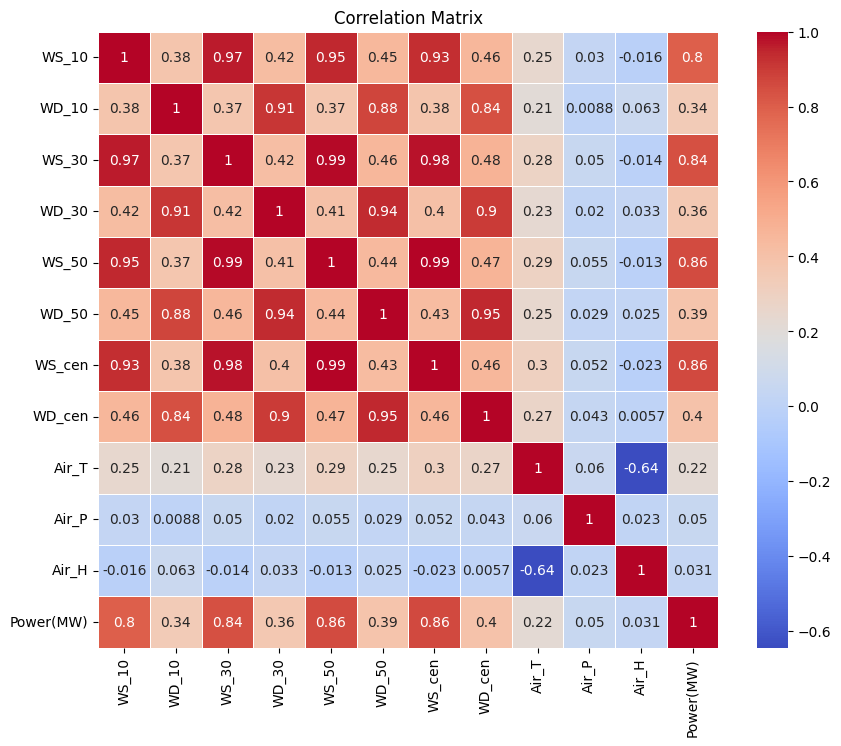

In [20]:
correlation_matrix = df_wf1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [21]:
pearsonr(df_wf1['WS_10'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.7998595044473402, pvalue=0.0)

In [22]:
pearsonr(df_wf1['WS_30'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8399594587604513, pvalue=0.0)

In [23]:
pearsonr(df_wf1['WS_50'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8563136119964339, pvalue=0.0)

In [24]:
pearsonr(df_wf1['WS_cen'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8617302465680039, pvalue=0.0)

With respect to the target variable [Power (MW)], the 4 below features have high correlations on top of very significant pvalues:
- 0.8 with Wind speed at height of 10 meters (m/s)
- 0.84 with Wind speed at height of 30 meters (m/s)
- 0.86 with Wind speed at height of 50 meters (m/s)
- 0.86 with Wind speed - at the height of wheel hub (m/s)

In [25]:
df_wf1.set_index('time', inplace=True)

In [26]:
df_wf1_train, df_wf1_test = train_test_split(df_wf1, train_size = 0.7, test_size = 0.3, shuffle=False)

In [27]:
df_wf1_train

WS_10    WD_10  WS_30    WD_30  WS_50    WD_50  WS_cen  \
time                                                                          
2019-01-01 00:00:00  2.209   81.317  1.991   74.814  2.094   77.667   2.494   
2019-01-01 00:15:00  1.828   77.460  1.698   75.048  1.757   88.733   1.882   
2019-01-01 00:30:00  2.193   86.700  2.313   84.688  2.344   89.100   2.350   
2019-01-01 00:45:00  2.654   78.160  2.494   74.939  2.574   87.267   2.808   
2019-01-01 01:00:00  2.249   94.297  2.192   91.140  2.558   96.900   2.924   
...                    ...      ...    ...      ...    ...      ...     ...   
2020-05-26 15:30:00  4.533  311.800  4.624  301.892  4.634  306.200   5.048   
2020-05-26 15:45:00  6.220  286.740  6.843  276.268  6.802  278.833   6.889   
2020-05-26 16:00:00  5.303  339.400  5.271  334.783  5.349  338.867   5.456   
2020-05-26 16:15:00  7.976  327.147  7.933  317.098  8.114  321.000   8.313   
2020-05-26 16:30:00  6.475  319.413  6.944  310.229  7.207  314.033   7.490   

                      WD_cen   Air_T    Air_P   Air_H  Power(MW)  
time                                                              
2019-01-01 00:00:00   74.500 -13.484  889.867  76.320   0.254383  
2019-01-01 00:15:00   74.367 -13.691  889.575  76.757   0.329703  
2019-01-01 00:30:00   89.000 -13.766  889.942  76.981   0.296306  
2019-01-01 00:45:00   82.733 -13.691  889.675  76.821   0.187590  
2019-01-01 01:00:00   92.967 -13.447  890.025  74.571   0.081005  
...                      ...     ...      ...     ...        ...  
2020-05-26 15:30:00  305.100  26.089  889.833  13.083  18.135082  
2020-05-26 15:45:00  275.483  26.131  889.400  12.425  16.923567  
2020-05-26 16:00:00  324.833  26.085  889.333  12.763  14.561643  
2020-05-26 16:15:00  322.233  26.664  889.267  11.780  24.755430  
2020-05-26 16:30:00  311.800  27.260  889.500  11.672  25.439707  

[49123 rows x 12 columns]

In [28]:
y_train = df_wf1_train.pop('Power(MW)')
X_train = df_wf1_train

In [29]:
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(estimator=lm, n_features_to_select=11)
rfe = rfe.fit(X_train, y_train)

In [30]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [31]:
X_train.columns[rfe.support_]

Index(['WS_10', 'WD_10', 'WS_30', 'WD_30', 'WS_50', 'WD_50', 'WS_cen',
       'WD_cen', 'Air_T', 'Air_P', 'Air_H'],
      dtype='object')

In [32]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

WS_10   WD_10  WS_30   WD_30  WS_50   WD_50  WS_cen  \
time                                                                       
2019-01-01 00:00:00  2.209  81.317  1.991  74.814  2.094  77.667   2.494   
2019-01-01 00:15:00  1.828  77.460  1.698  75.048  1.757  88.733   1.882   
2019-01-01 00:30:00  2.193  86.700  2.313  84.688  2.344  89.100   2.350   
2019-01-01 00:45:00  2.654  78.160  2.494  74.939  2.574  87.267   2.808   
2019-01-01 01:00:00  2.249  94.297  2.192  91.140  2.558  96.900   2.924   

                     WD_cen   Air_T    Air_P   Air_H  
time                                                  
2019-01-01 00:00:00  74.500 -13.484  889.867  76.320  
2019-01-01 00:15:00  74.367 -13.691  889.575  76.757  
2019-01-01 00:30:00  89.000 -13.766  889.942  76.981  
2019-01-01 00:45:00  82.733 -13.691  889.675  76.821  
2019-01-01 01:00:00  92.967 -13.447  890.025  74.571

In [33]:
def build_model(X,y):
    X = sm.add_constant(X) #Adding the constant
    lm = sm.OLS(y,X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X

def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [34]:
X_train_new = build_model(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                 1.396e+04
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        06:36:16   Log-Likelihood:            -1.8951e+05
No. Observations:               49123   AIC:                         3.791e+05
Df Residuals:                   49111   BIC:                         3.792e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -66.7004     16.262     -4.101      0.0

In [35]:
checkVIF(X_train_new)

Features       VIF
0     const  98869.61
5     WS_50    351.15
3     WS_30    163.04
7    WS_cen    127.99
1     WS_10     20.00
6     WD_50     16.02
4     WD_30     12.22
8    WD_cen     10.32
2     WD_10      6.65
9     Air_T      2.16
11    Air_H      1.92
10    Air_P      1.02

In [36]:
X_train_new = X_train_new.drop(["WS_50"], axis = 1)
checkVIF(X_train_new)

Features       VIF
0     const  98661.83
3     WS_30     55.92
6    WS_cen     27.12
1     WS_10     17.34
5     WD_50     16.01
4     WD_30     12.20
7    WD_cen     10.30
2     WD_10      6.64
8     Air_T      2.15
10    Air_H      1.92
9     Air_P      1.02

In [37]:
X_train_new = X_train_new.drop(["WS_30"], axis = 1)
checkVIF(X_train_new)

Features       VIF
0    const  98498.94
4    WD_50     15.81
3    WD_30     12.19
6   WD_cen     10.15
5   WS_cen      8.07
1    WS_10      7.84
2    WD_10      6.12
7    Air_T      2.15
9    Air_H      1.92
8    Air_P      1.02

In [38]:
X_train_new = X_train_new.drop(["WD_50"], axis = 1)
checkVIF(X_train_new)

Features       VIF
0    const  98492.68
3    WD_30      9.53
4   WS_cen      8.04
1    WS_10      7.79
2    WD_10      6.08
5   WD_cen      5.65
6    Air_T      2.15
8    Air_H      1.92
7    Air_P      1.02

In [39]:
X_train_new = X_train_new.drop(["WD_30"], axis = 1)
checkVIF(X_train_new)

Features       VIF
0    const  98492.58
3   WS_cen      7.90
1    WS_10      7.61
4   WD_cen      3.73
2    WD_10      3.41
5    Air_T      2.15
7    Air_H      1.92
6    Air_P      1.02

In [40]:
X_train_new = X_train_new.drop(["WS_cen"], axis = 1)
checkVIF(X_train_new)

Features       VIF
0    const  98234.09
3   WD_cen      3.72
2    WD_10      3.40
4    Air_T      2.04
6    Air_H      1.87
1    WS_10      1.30
5    Air_P      1.02

In [41]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 1.504e+04
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        06:36:18   Log-Likelihood:            -1.9871e+05
No. Observations:               49123   AIC:                         3.974e+05
Df Residuals:                   49116   BIC:                         3.975e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -191.1760     19.547     -9.780      0.0

In [42]:
X_train_new = X_train_new.drop(["WD_cen"], axis = 1)
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                 1.803e+04
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        06:36:18   Log-Likelihood:            -1.9873e+05
No. Observations:               49123   AIC:                         3.975e+05
Df Residuals:                   49117   BIC:                         3.975e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -198.4182     19.517    -10.167      0.0

In [43]:
lm = sm.OLS(y_train,X_train_new).fit()
y_train_price = lm.predict(X_train_new)

In [44]:
scaler = MinMaxScaler()
num_vars = ['WD_10','WS_10', 'Air_T', 'Air_P', 'Air_H']
df_wf1_test[num_vars] = scaler.fit_transform(df_wf1_test[num_vars])

In [45]:
y_test = df_wf1_test.pop('Power(MW)')
X_test = df_wf1_test

In [46]:
# Now let's use our model to make predictions.
X_train_new = X_train_new.drop('const',axis=1)
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable
X_test_new = sm.add_constant(X_test_new)

In [47]:
# Making predictions
y_pred = lm.predict(X_test_new)

In [48]:
r2_score(y_test, y_pred)

-74.79978840253223

Text(0, 0.5, 'y_pred')

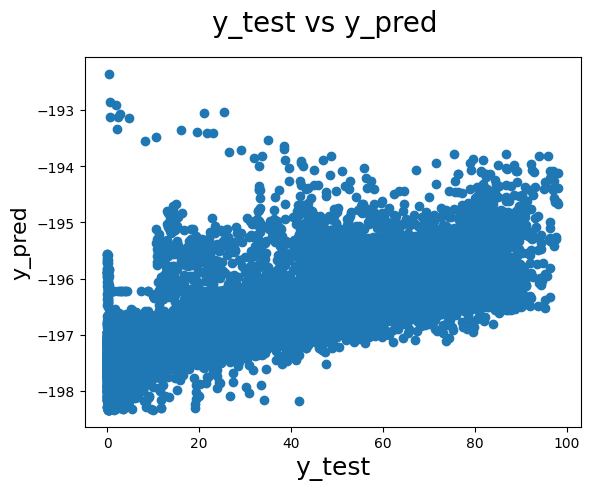

In [49]:
#EVALUATION OF THE MODEL
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)

In [50]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                 1.803e+04
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        06:36:19   Log-Likelihood:            -1.9873e+05
No. Observations:               49123   AIC:                         3.975e+05
Df Residuals:                   49117   BIC:                         3.975e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -198.4182     19.517    -10.167      0.0

In [51]:
df_wf1_train

WS_10    WD_10  WS_30    WD_30  WS_50    WD_50  WS_cen  \
time                                                                          
2019-01-01 00:00:00  2.209   81.317  1.991   74.814  2.094   77.667   2.494   
2019-01-01 00:15:00  1.828   77.460  1.698   75.048  1.757   88.733   1.882   
2019-01-01 00:30:00  2.193   86.700  2.313   84.688  2.344   89.100   2.350   
2019-01-01 00:45:00  2.654   78.160  2.494   74.939  2.574   87.267   2.808   
2019-01-01 01:00:00  2.249   94.297  2.192   91.140  2.558   96.900   2.924   
...                    ...      ...    ...      ...    ...      ...     ...   
2020-05-26 15:30:00  4.533  311.800  4.624  301.892  4.634  306.200   5.048   
2020-05-26 15:45:00  6.220  286.740  6.843  276.268  6.802  278.833   6.889   
2020-05-26 16:00:00  5.303  339.400  5.271  334.783  5.349  338.867   5.456   
2020-05-26 16:15:00  7.976  327.147  7.933  317.098  8.114  321.000   8.313   
2020-05-26 16:30:00  6.475  319.413  6.944  310.229  7.207  314.033   7.490   

                      WD_cen   Air_T    Air_P   Air_H  
time                                                   
2019-01-01 00:00:00   74.500 -13.484  889.867  76.320  
2019-01-01 00:15:00   74.367 -13.691  889.575  76.757  
2019-01-01 00:30:00   89.000 -13.766  889.942  76.981  
2019-01-01 00:45:00   82.733 -13.691  889.675  76.821  
2019-01-01 01:00:00   92.967 -13.447  890.025  74.571  
...                      ...     ...      ...     ...  
2020-05-26 15:30:00  305.100  26.089  889.833  13.083  
2020-05-26 15:45:00  275.483  26.131  889.400  12.425  
2020-05-26 16:00:00  324.833  26.085  889.333  12.763  
2020-05-26 16:15:00  322.233  26.664  889.267  11.780  
2020-05-26 16:30:00  311.800  27.260  889.500  11.672  

[49123 rows x 11 columns]

In [52]:
# Define features and target variable
X = df_wf1.drop(columns=['Power(MW)']).values
y = df_wf1['Power(MW)'].values

# Normalize features including all columns
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input data for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1)

# Make predictions
predictions_scaled = model.predict(X_test)

# Inverse transform predictions
predictions = scaler_y.inverse_transform(predictions_scaled)

Epoch 1/100
1123/1123 [==============================] - 6s 3ms/step - loss: 0.0186
Epoch 2/100
1123/1123 [==============================] - 3s 3ms/step - loss: 0.0145
Epoch 3/100
1123/1123 [==============================] - 4s 4ms/step - loss: 0.0138
Epoch 4/100
1123/1123 [==============================] - 3s 3ms/step - loss: 0.0131
Epoch 5/100
1123/1123 [==============================] - 3s 3ms/step - loss: 0.0119
Epoch 6/100
1123/1123 [==============================] - 4s 3ms/step - loss: 0.0107
Epoch 7/100
1123/1123 [==============================] - 4s 4ms/step - loss: 0.0102
Epoch 8/100
1123/1123 [==============================] - 3s 3ms/step - loss: 0.0101
Epoch 9/100
1123/1123 [==============================] - 3s 3ms/step - loss: 0.0100
Epoch 10/100
1123/1123 [==============================] - 4s 4ms/step - loss: 0.0100
Epoch 11/100
1123/1123 [==============================] - 4s 3ms/step - loss: 0.0099
Epoch 12/100
1123/1123 [==============================] - 3s 3ms/step - lo

KeyboardInterrupt: 

In [ ]:
y_test_actual = scaler_y.inverse_transform(y_test)
mae = mean_absolute_error(y_test_actual, predictions)
print(mae)

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.title('Actual vs Predicted Power(MW)')
plt.legend()
plt.show()

In [65]:
#for XGBoost

X_train_reshaped = np.reshape(X_train, (56140, 11))
X_train_reshaped.shape

In [64]:
y_train.shape

(56140, 1)

In [61]:
pip install xgboost

In [67]:
import xgboost as xgb

model = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=150)
model.fit(X_train_reshaped, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [69]:
X_test.shape

(14036, 1, 11)

In [70]:
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
predictions = model.predict(X_test_reshaped)

In [71]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.00851213040940332


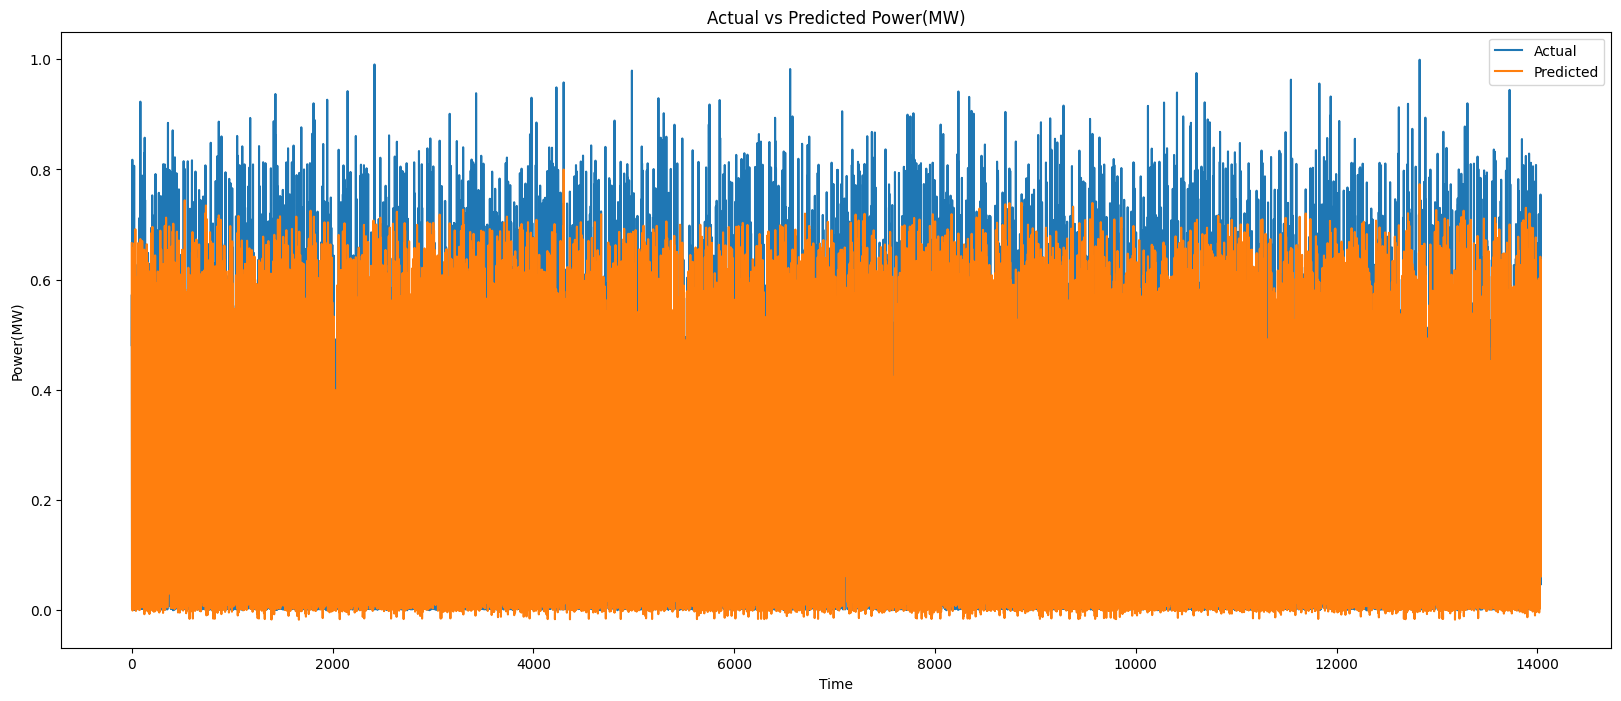

In [75]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.title('Actual vs Predicted Power(MW)')
plt.legend()
plt.show()